This notebook provides the solution for the Assignment 2.



In [1]:
'''
This block only installs the necessary dependencies onto the system. If the libs are already installed, then no need to execute this command.
'''
%pip install matplotlib
%pip install yfinance
%pip install pandas==1.5.3
%pip install empyrical
%pip install pydantic
%pip install ta

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import the libs
import pandas as pd
import pandas as pd
import yfinance as yf
import pyfolio as pf
import datetime as dt
import empyrical as em
import ta
import numpy as np
from pydantic import BaseModel
import warnings

# Ignore printing all warnings
warnings.filterwarnings('ignore')

/home/gaurasha/Workshop/MBAZG555/.venv/lib64/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
class Settings( BaseModel ):
    period   : str = "1y"
    interval : str = "1d"
    tmp_folder: str = 'tmp'
    yahoo_ticker_ext: str = ".NS"

setting = Settings( )

# download the data from yfinance
stock_symbol = "ICICIBANK.NS" 
drop_column_list =  ['Open', 'High', 'Low', 'Volume', 'Stock Splits', 'Dividends']

ticker = yf.Ticker( stock_symbol )
ticker_df = ticker.history( period=setting.period, interval=setting.interval )
ticker_df.dropna(inplace = True)
ticker_df['daily_returns'] = np.log(ticker_df['Close']/ticker_df['Close'].shift(1))

ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

ticker_df.head( )

,Close,daily_returns
Date,,
2023-03-08 00:00:00+05:30,864.980042,NaN
2023-03-09 00:00:00+05:30,848.961914,-0.018692
2023-03-10 00:00:00+05:30,835.770569,-0.015660
2023-03-13 00:00:00+05:30,821.636902,-0.017056
2023-03-14 00:00:00+05:30,823.570923,0.002351


Start date,2023-03-08
End date,2024-03-07
Total months,11
,Backtest
Annual return,7.2%
Cumulative returns,7.0%
Annual volatility,12.2%
Sharpe ratio,0.68
Calmar ratio,0.55
Stability,0.23
Max drawdown,-12.9%


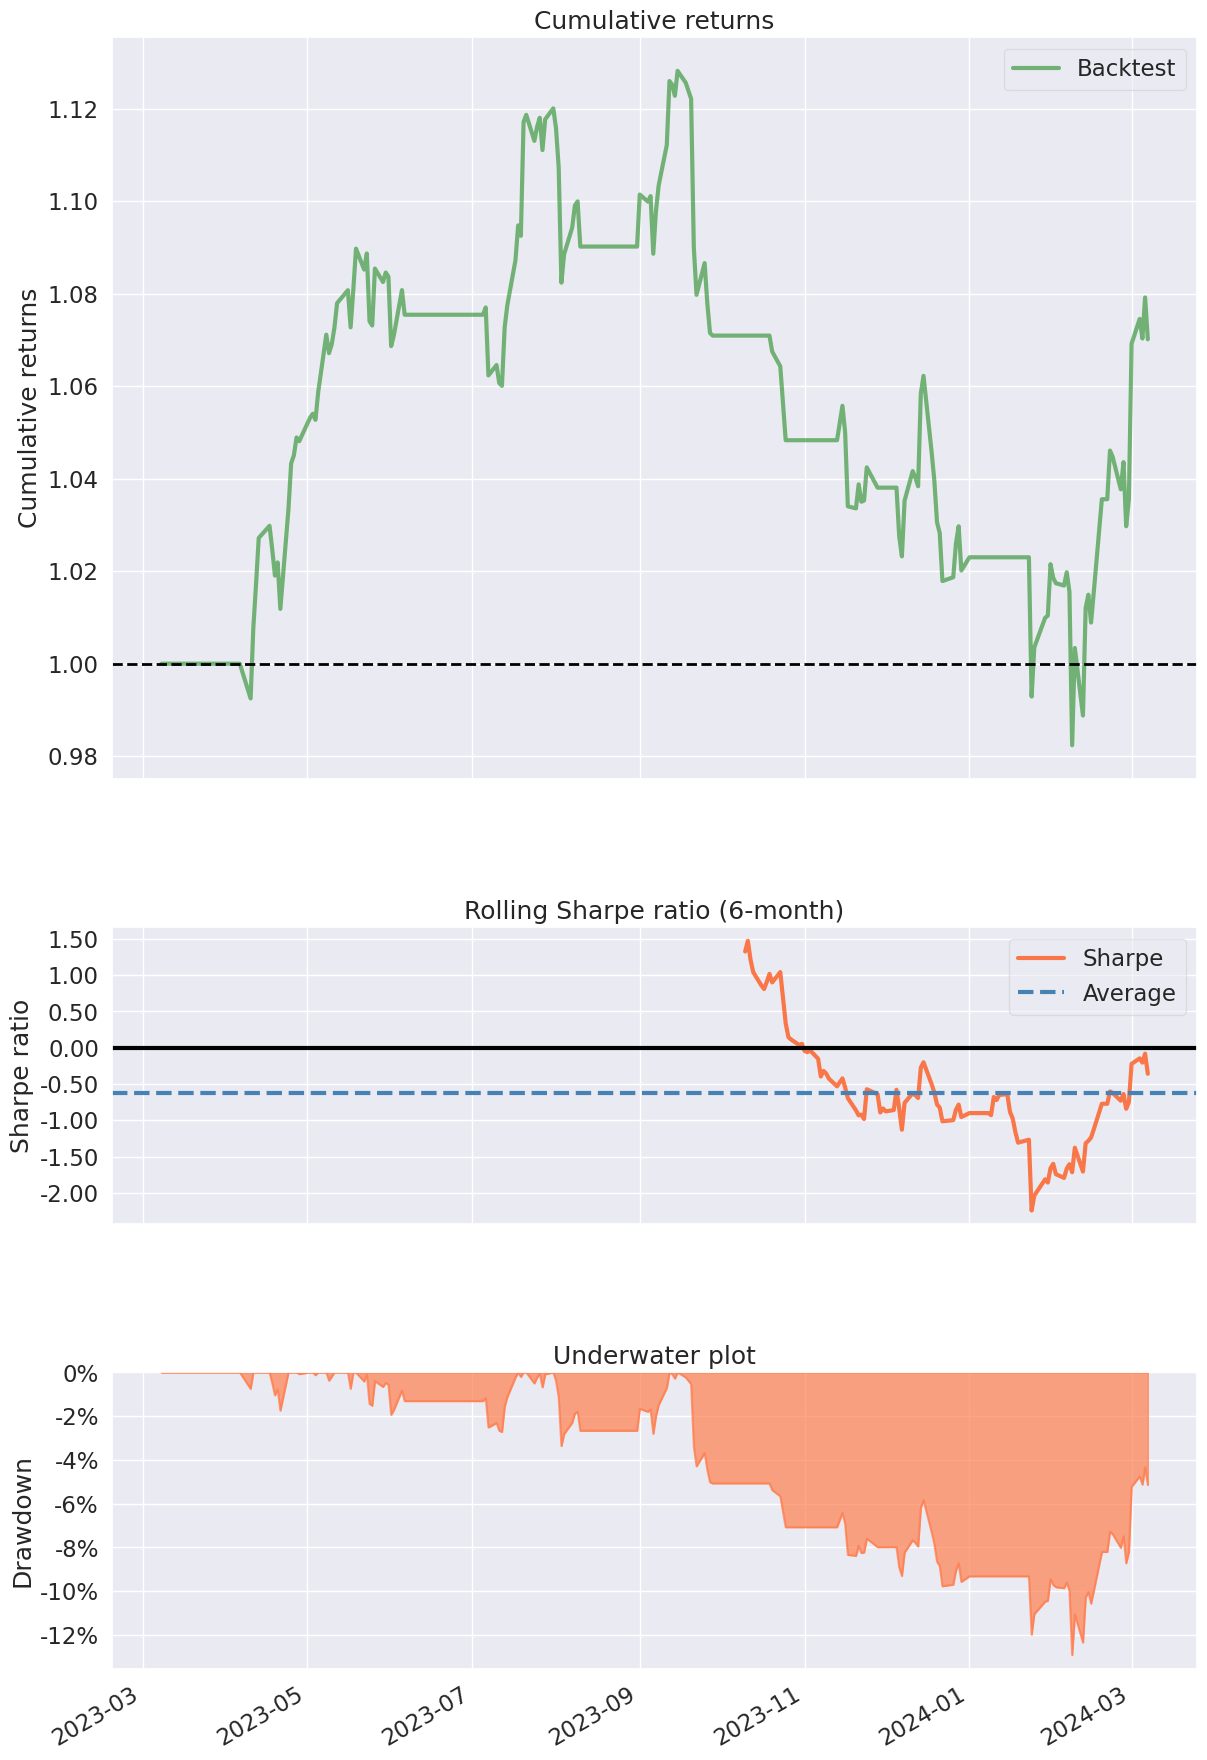

In [4]:
# Setting up the calculations for Simple Moving Average - Cross Over

df_sma = ticker_df.copy( deep=True )
long_window  = 20
short_window = 10

df_sma[ 'short'] = ta.trend.SMAIndicator( df_sma['Close'], window=short_window).sma_indicator()
df_sma[ 'long' ] = ta.trend.SMAIndicator( df_sma['Close'], window=long_window ).sma_indicator()

# SMA Cross over Strategy 

# Position Strategy
# BUY condition
df_sma['sma_signal'] = np.where((df_sma['short'] > df_sma['long']),1,np.nan)
# SELL condition
df_sma['sma_signal'] = np.where( (df_sma['short'] < df_sma['long']),0,df_sma['sma_signal'])

# creating long and short positions
df_sma['sma_position'] = df_sma['sma_signal'].replace(to_replace=np.nan, method='ffill')

# shifting by 1, to account of close price return calculations
df_sma['sma_position'] = df_sma['sma_position'].shift(1)

# calculating returns
df_sma['returns'] = df_sma['daily_returns'] * (df_sma['sma_position'])

df_sma['returns'].describe()

df_sma.head(50)
pf.create_simple_tear_sheet( df_sma['returns'] )
